# Pipeline

In [26]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

# paths
ROOT_PATH = Path('/home/downloads/carnd-p5-vehicle-detection')

## Utilities

In [27]:
def read_image(img_path):
    if img_path.endswith('.png'):
        img = plt.imread(img_path)*255
        img = np.clip(img, 0, 255).astype(np.uint8)
    else:
        img = plt.imread(img_path)
    
    return img

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color_rgb(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LAB':
            cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else:
        cvt_image = np.copy(image)
    
    return cvt_image

def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    hog_features = hog(img, orientations=orient, 
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                visualize=False, feature_vector=feature_vec, block_norm='L2-Hys')
    return hog_features

def extract_features(image, cspace='RGB', orient=9, pix_per_cell=8, 
                     spatial_size=(32, 32), hist_bins=32,
                     cell_per_block=2, hog_channel=0, spatial_feat=True,
                     hist_feat=True, hog_feat=True):
    feature_image = convert_color_rgb(image, cspace)
    
    img_features = []
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for ch in range(feature_image.shape[2]):
                hog_features_ch = extract_hog_features(image[:, :, ch], orient, pix_per_cell, cell_per_block, feature_vec=True)
                hog_features.append(hog_features_ch)
            hog_features = np.ravel(hog_features)

        else:
            hog_features = extract_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, feature_vec=True)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Training a classifier

In [28]:
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

In [33]:
model = pickle.load(open(ROOT_PATH/'models/model_ver1.pkl', 'rb'))

X_scaler = model['scaler']
svc = model['svc']

## Sliding windows

In [34]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [35]:
def slide_window(img, x_start_stop=[0, None], y_start_stop=[0, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # number of windows in x and y
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list = []
    for xs in range(nx_windows):
        for ys in range(ny_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [36]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #print(features.shape)
            #plt.imshow(test_img)
            #plt.show()
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [37]:
def slide_and_search(img, y_start_stop, xstart_stop, classifier, scaler, xy_window, xy_overlap, cspace, 
                     spatial_size, hist_bins, orient, pix_per_cell, 
                     cell_per_block, hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True):
    # crop the image
    windows = slide_window(img, xy_window=xy_window, xy_overlap=xy_overlap, x_start_stop=x_start_stop, y_start_stop=y_start_stop)
    hot_windows = search_windows(img, windows, svc, X_scaler, cspace=cspace,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    return windows, hot_windows

In [38]:
def draw_windows(img, windows, hot_windows, vis_search=False):
    if vis_search:
        img = draw_boxes(img, windows, color=(242, 255, 191))
    img = draw_boxes(img, hot_windows, color=(216, 48, 10))
    
    return img

In [39]:
test_image_path = ROOT_PATH/'images/test_images/test5.jpg'
#test_image_path = ROOT_PATH/'images/test_images/17.png'
test_image = read_image(test_image_path.as_posix())

CPU times: user 775 ms, sys: 3.97 ms, total: 779 ms
Wall time: 778 ms


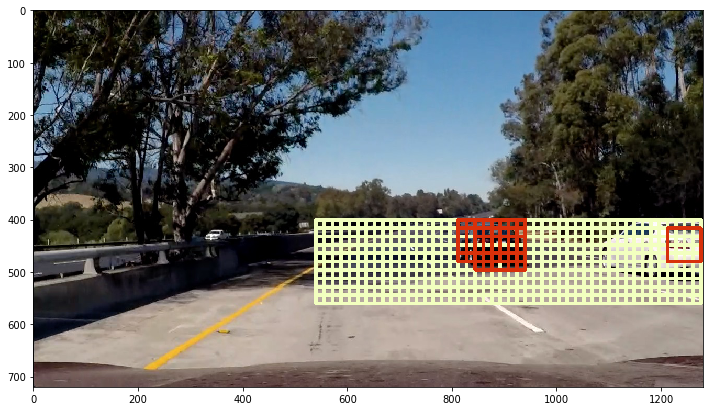

In [40]:
%%time
xy_window = (64, 64)
xy_overlap = (0.75, 0.75)
y_start_stop = (400, 560)
x_start_stop = (540, 1280)
windows, hot_windows = slide_and_search(test_image, y_start_stop, x_start_stop, svc, X_scaler, xy_window, xy_overlap, cspace=cspace,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
result_image = draw_windows(test_image, windows, hot_windows, vis_search=True)
plt.figure(figsize=(12, 9))
plt.imshow(result_image)

CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 403 ms


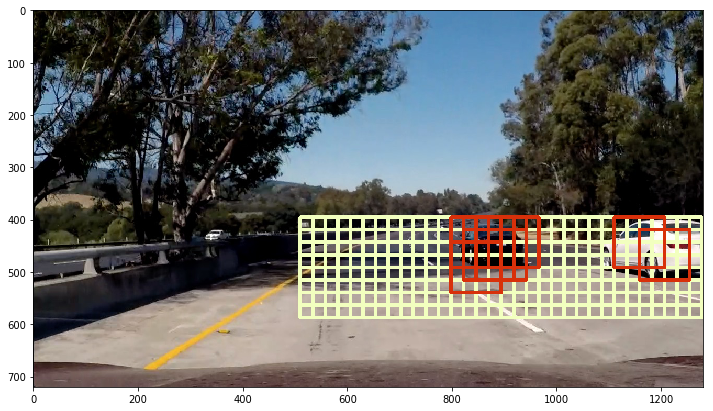

In [41]:
%%time
xy_window = (96, 96)
xy_overlap = (0.75, 0.75)
y_start_stop = (395, 600)
x_start_stop = (510, 1280)
windows, hot_windows = slide_and_search(test_image, y_start_stop, x_start_stop, svc, X_scaler, xy_window, xy_overlap, cspace=cspace,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
result_image = draw_windows(test_image, windows, hot_windows, vis_search=True)
plt.figure(figsize=(12, 9))
plt.imshow(result_image)

CPU times: user 337 ms, sys: 38 µs, total: 337 ms
Wall time: 336 ms


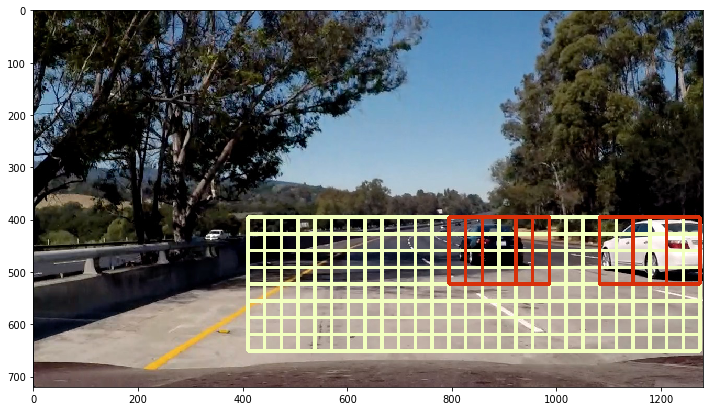

In [42]:
%%time
xy_window = (128, 128)
xy_overlap = (0.75, 0.75)
y_start_stop = (395, 660)
x_start_stop = (410, 1280)
windows, hot_windows = slide_and_search(test_image, y_start_stop, x_start_stop, svc, X_scaler, xy_window, xy_overlap, cspace=cspace,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
result_image = draw_windows(test_image, windows, hot_windows, vis_search=True)
plt.figure(figsize=(12, 9))
plt.imshow(result_image)

### Multiple detections and false positive

In [43]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# def filter_heatmap_with_thresh(heatmap, labels, thresh):
#     num_labels = 0
#     for car_number in range(1, labels[1]+1):
#         nonzero = (labels[0] == car_number).nonzero()
#         box_size = (np.max(nonzerox)-np.min(nonzerox))*(np.max(nonzeroy)-np.min(nonzeroy))
#         if box_size < thresh:
#             labels[0][nonzeros[0], nonzero[1]] = 0      

In [44]:
%%time
test_image_path = ROOT_PATH/'images/test_images/test6.jpg'
test_image = read_image(test_image_path.as_posix())

window_list = [
    #(48, 0.55, 405, 520, 500, 1280),
    (64, 0.75, 400, 560, 540, 1280),
    #(80, 0.75, 390, 560, 350, 1280),
    (96, 0.75, 395, 600, 510, 1280),
    #(116, 0.5, 400, 650, 200, 1280),
    #(110, 0.65, 390, 700, 330, 1280),
    (128, 0.75, 395, 700, 410, 1280)
]

threshold_detect = 2

def detect_cars(img, window_list, threshold_detect, classifier, 
                scaler, cspace, spatial_size, hist_bins, orient, pix_per_cell, 
                cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    
    for window, overlap, ystart, ystop, xstart, xstop in window_list:
        xy_window = (window, window)
        xy_overlap = (overlap, overlap)
        y_start_stop = (ystart, ystop)
        x_start_stop = (xstart, xstop)
        _, hot_windows = slide_and_search(img, y_start_stop, x_start_stop, classifier, scaler, xy_window, xy_overlap, 
                                          cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                                          orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                          hist_feat=hist_feat, hog_feat=hog_feat)
        heat = add_heat(heat, hot_windows)
    
    # apply the threhold
    heat = apply_threshold(heat, threshold_detect)
    
    # create heatmap and labels
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    return heatmap, labels
 

heatmap, labels = detect_cars(test_image, window_list, threshold_detect, svc, X_scaler, cspace=cspace,  
                              spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                              hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                              hog_feat=hog_feat)

CPU times: user 1.74 s, sys: 3.91 ms, total: 1.74 s
Wall time: 1.74 s


/home/downloads/carnd-p5-vehicle-detection/images/test_images/test4.jpg
number of labels:  2


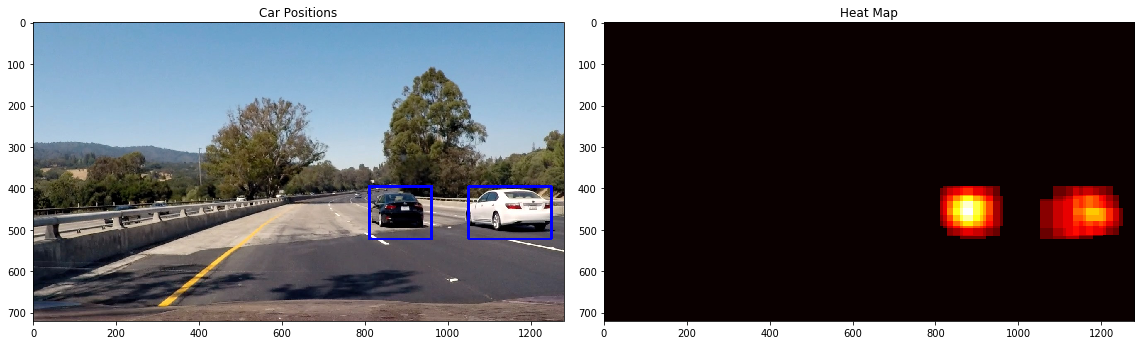

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test3.jpg
number of labels:  1


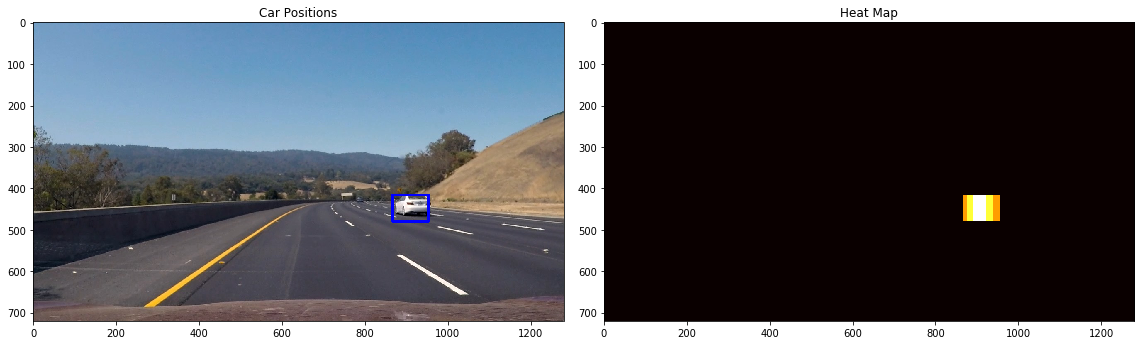

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test1.jpg
number of labels:  2


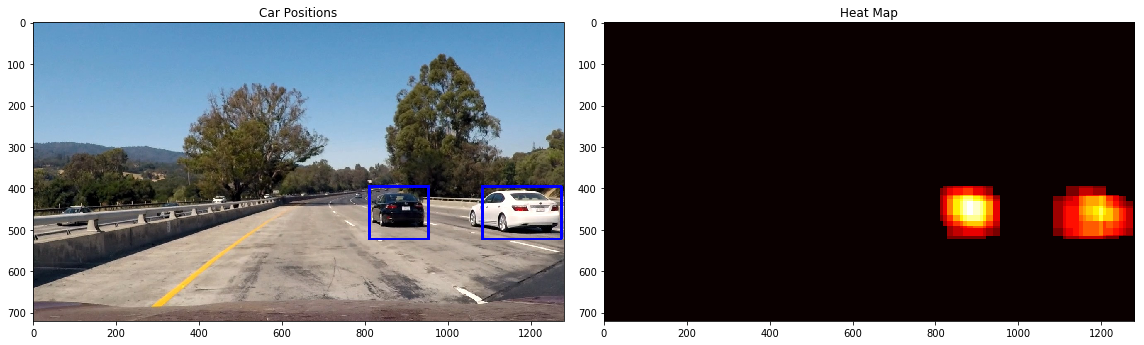

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test6.jpg
number of labels:  2


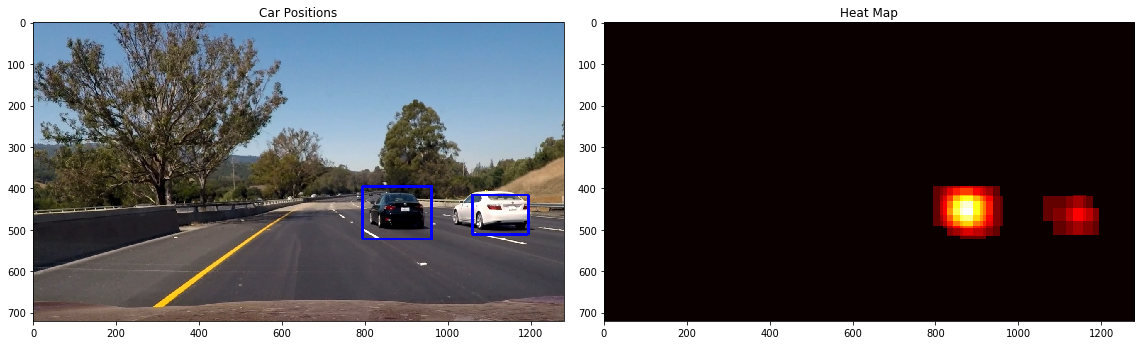

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test2.jpg
number of labels:  0


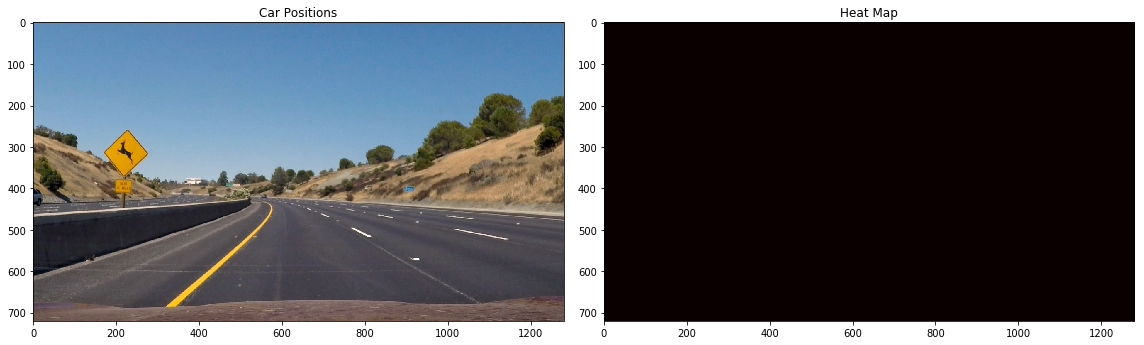

/home/downloads/carnd-p5-vehicle-detection/images/test_images/test5.jpg
number of labels:  2


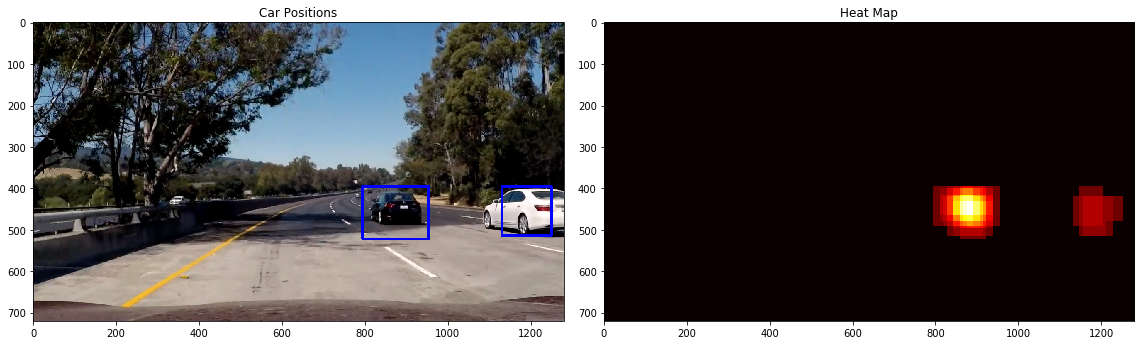

In [45]:
for img_path in (ROOT_PATH/'images/test_images').glob('*jpg'):
    print(img_path)
    img = read_image(img_path.as_posix())
    heatmap, labels = detect_cars(img, window_list, threshold_detect, svc, X_scaler, cspace=cspace,  
                              spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                              hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                              hog_feat=hog_feat)
    print('number of labels: ', labels[1])
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize=(16,12))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    
    plt.show()

/home/downloads/carnd-p5-vehicle-detection/images/test_images/25.png
number of labels:  1


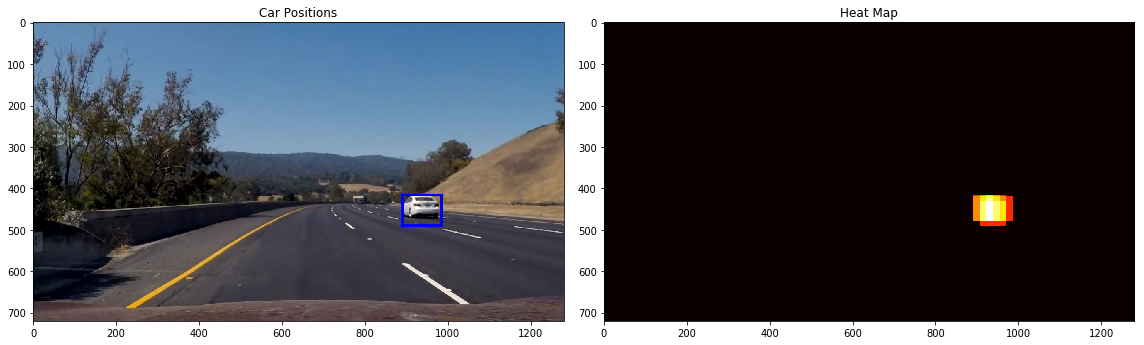

/home/downloads/carnd-p5-vehicle-detection/images/test_images/15.png
number of labels:  1


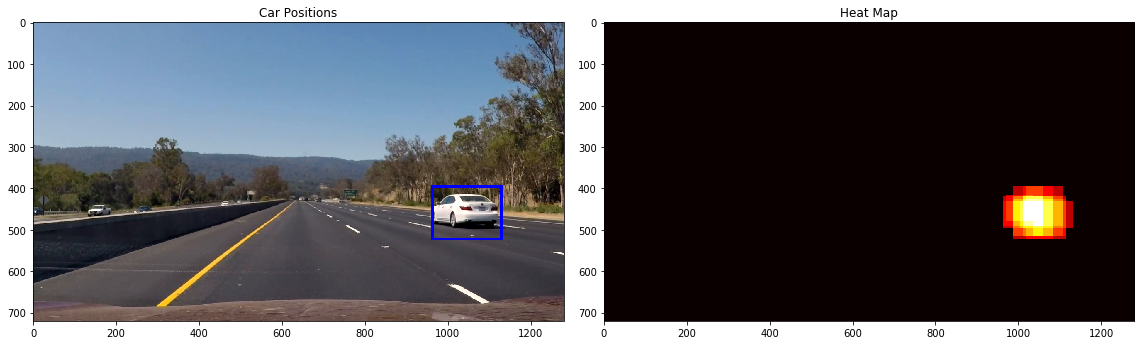

/home/downloads/carnd-p5-vehicle-detection/images/test_images/13.png
number of labels:  1


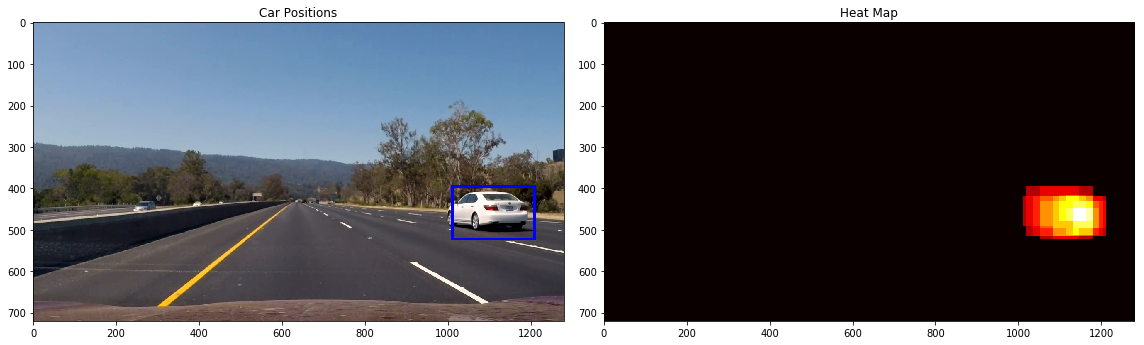

/home/downloads/carnd-p5-vehicle-detection/images/test_images/17.png
number of labels:  1


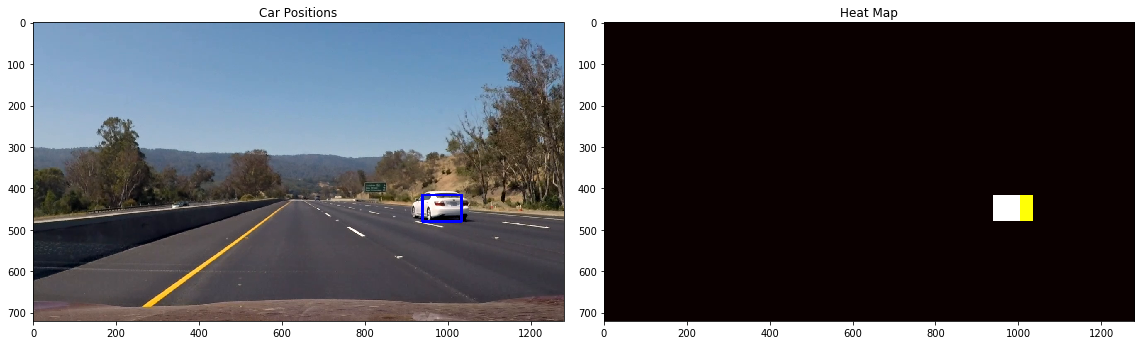

/home/downloads/carnd-p5-vehicle-detection/images/test_images/23.png
number of labels:  1


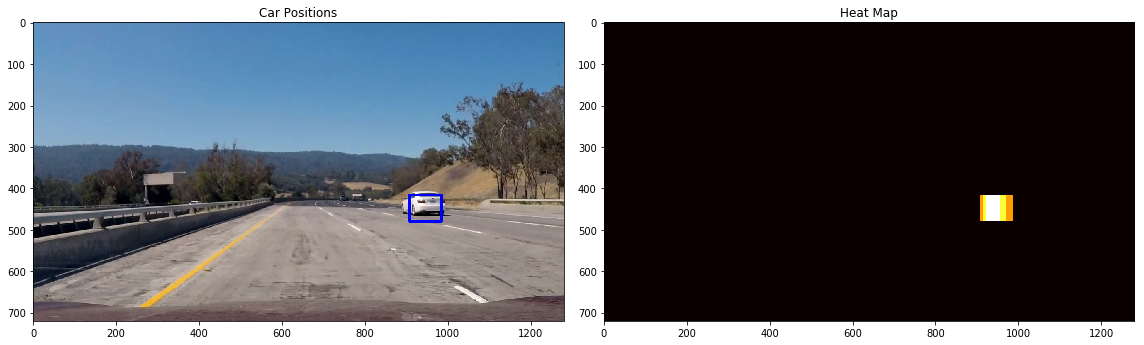

/home/downloads/carnd-p5-vehicle-detection/images/test_images/22.png
number of labels:  1


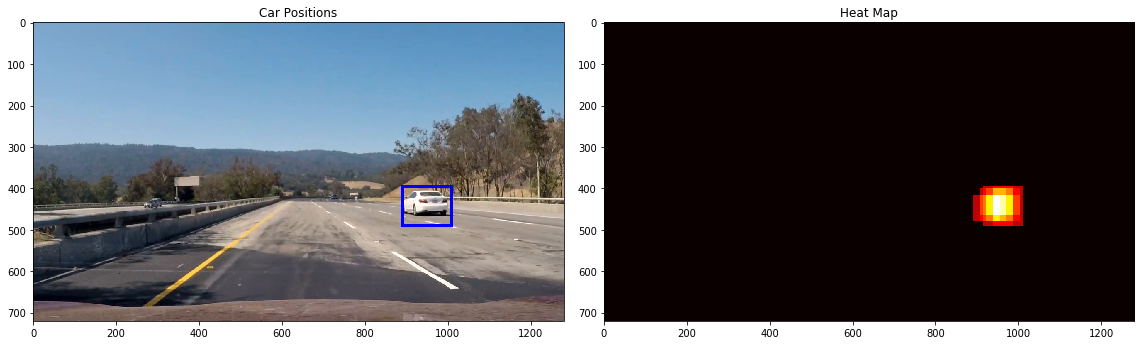

/home/downloads/carnd-p5-vehicle-detection/images/test_images/19.png
number of labels:  1


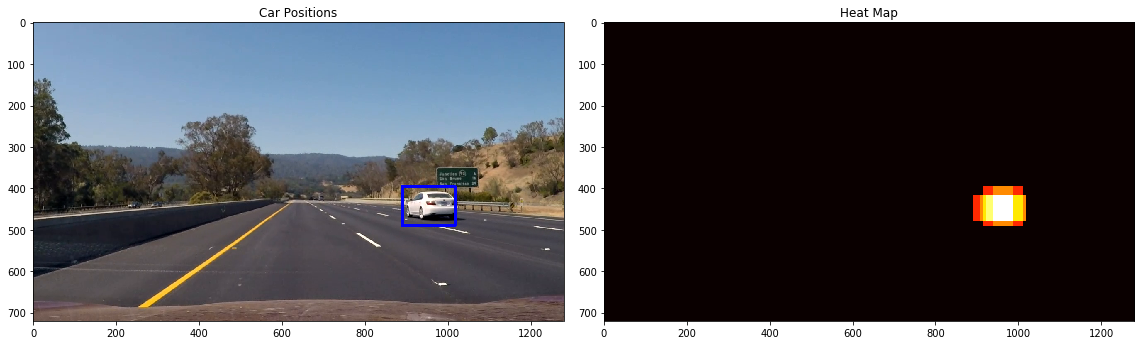

/home/downloads/carnd-p5-vehicle-detection/images/test_images/26.png
number of labels:  1


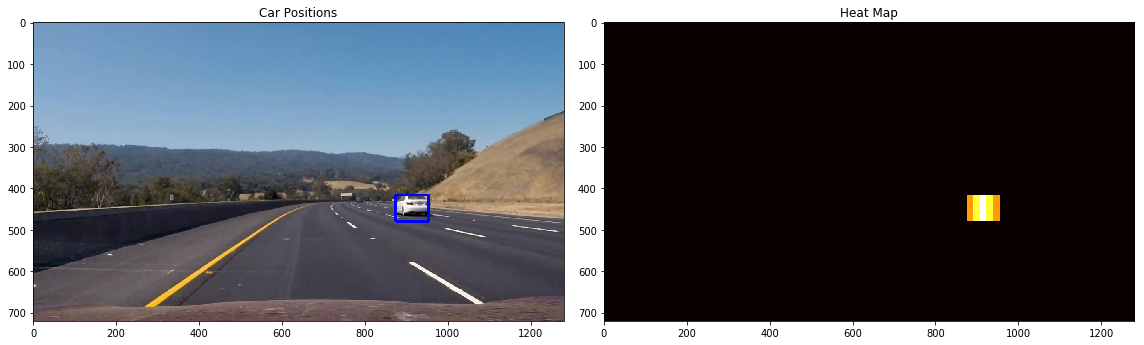

/home/downloads/carnd-p5-vehicle-detection/images/test_images/27.png
number of labels:  1


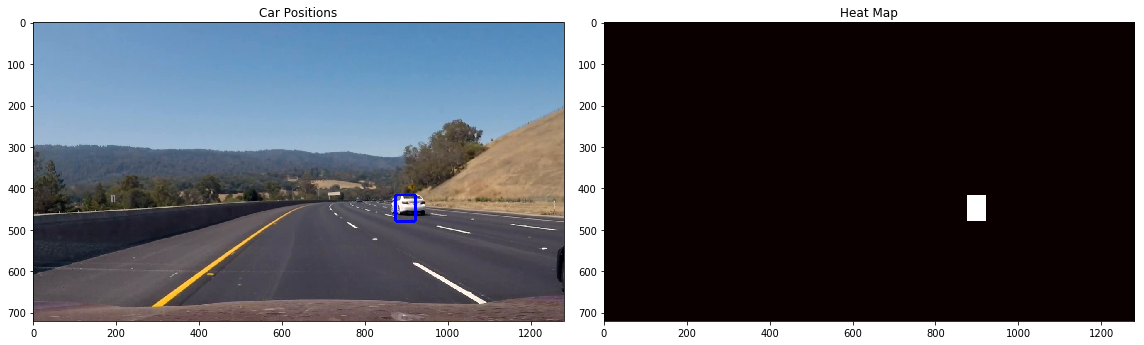

/home/downloads/carnd-p5-vehicle-detection/images/test_images/20.png
number of labels:  1


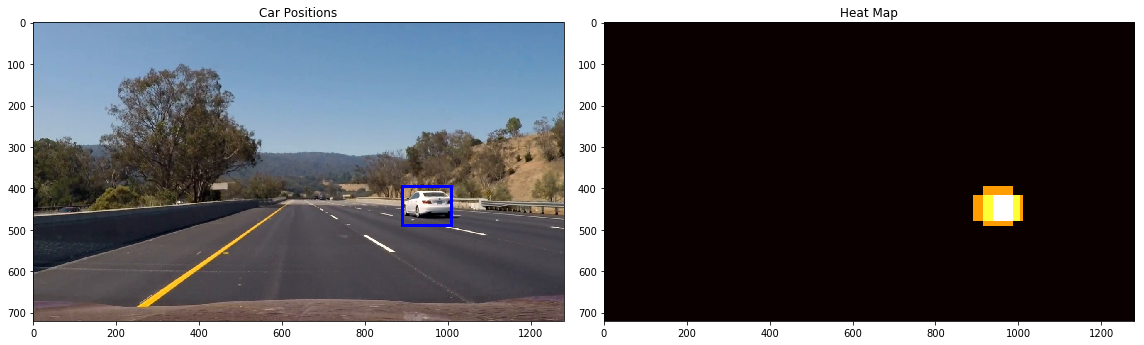

/home/downloads/carnd-p5-vehicle-detection/images/test_images/24.png
number of labels:  1


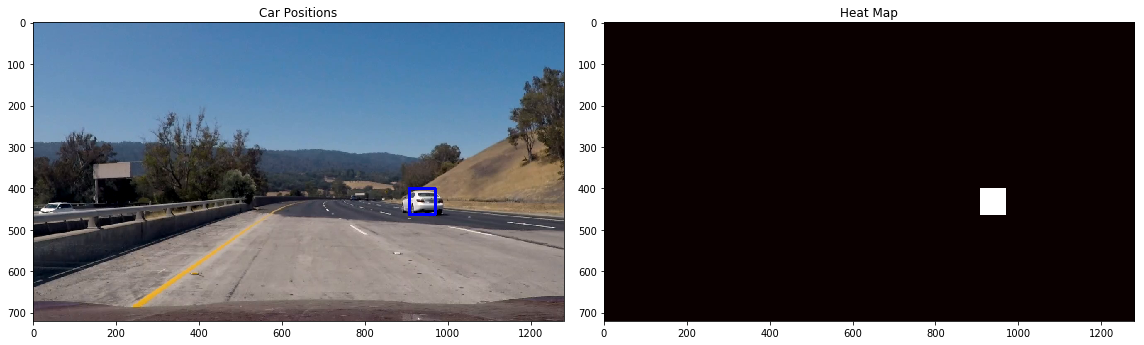

/home/downloads/carnd-p5-vehicle-detection/images/test_images/21.png
number of labels:  1


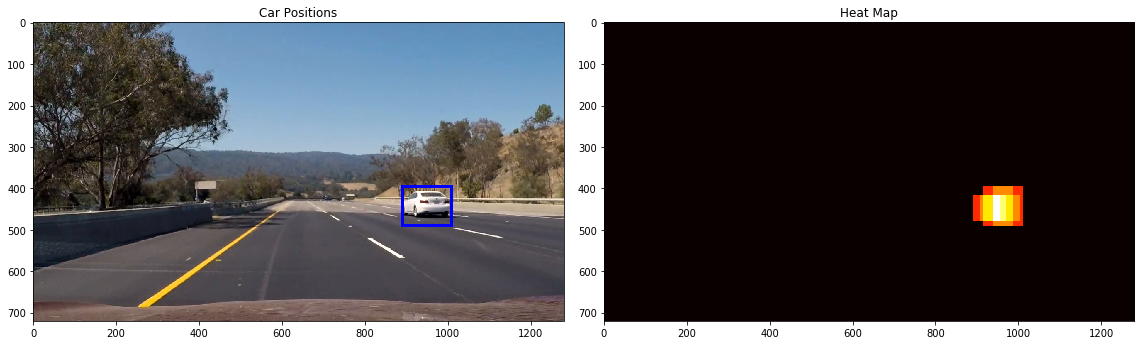

/home/downloads/carnd-p5-vehicle-detection/images/test_images/11.png
number of labels:  1


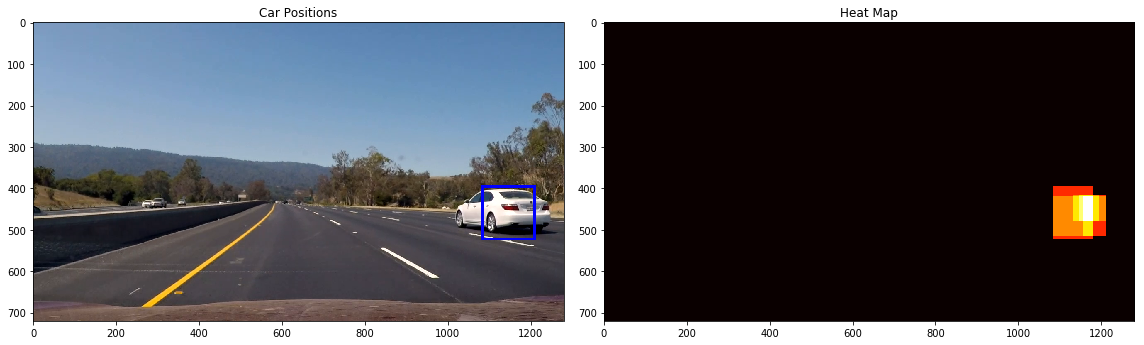

In [46]:
for img_path in (ROOT_PATH/'images/test_images').glob('*png'):
    print(img_path)
    img = read_image(img_path.as_posix())
    heatmap, labels = detect_cars(img, window_list, threshold_detect, svc, X_scaler, cspace=cspace,  
                              spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                              hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                              hog_feat=hog_feat)
    print('number of labels: ', labels[1])
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize=(16,12))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    
    plt.show()

## Video pipeline

In [19]:
class CarDetector():
    def __init__(self, scales, threshold, classifier, scaler, cspace='YCrCb', 
                 orient=10, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_size=(16, 16), 
                 hist_bins=16, num_history=10, diagnosis=False):
        self.scales = scales
        #self.windows_list = windows_list
        self.threshold = threshold
        
        self.classifier = classifier
        self.scaler = scaler
        
        self.cspace = cspace
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.diagnosis = diagnosis
        
        # store the heatmaps 
        self.heatmap_list = deque(maxlen=num_history)
    
    def detect(self, img):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        for window, overlap, ystart, ystop, xstart, xstop in window_list:
            xy_window = (window, window)
            xy_overlap = (overlap, overlap)
            y_start_stop = (ystart, ystop)
            x_start_stop = (xstart, xstop)
            _, hot_windows = slide_and_search(img, y_start_stop, x_start_stop, self.classifier,self. scaler, 
                                              xy_window, xy_overlap, cspace=self.cspace, 
                                              spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                              orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                              cell_per_block=self.cell_per_block, hog_channel=self.hog_channel)
            heat = add_heat(heat, hot_windows)
        
        return heat
        
    def apply_thresh_on_sum(self, heat):
        self.heatmap_list.append(heat)
        heatmap = np.sum(np.array(self.heatmap_list), axis=0)
        if self.diagnosis:
            fig, axes = plt.subplots(1, 2, figsize=(12, 9))
            axes[0].imshow(heatmap, cmap='hot')
            heatmap = apply_threshold(heatmap, self.threshold)
            axes[1].imshow(heatmap, cmap='hot')
            plt.show()
        else:
            heatmap = apply_threshold(heatmap, self.threshold)
        heatmap = np.clip(heatmap, 0, 255)
        
        labels = label(heatmap)
        
        return labels 
    
    def process(self, img):
        heat = self.detect(img)
        labels = self.apply_thresh_on_sum(heat)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

VIDEO_INPUT_PATH = Path(ROOT_PATH)/'videos/test_videos'
VIDEO_OUTPUT_PATH = Path(ROOT_PATH)/'videos/test_videos_result'

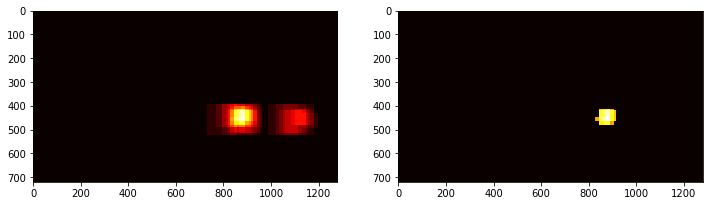

[MoviePy] >>>> Building video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result.mp4


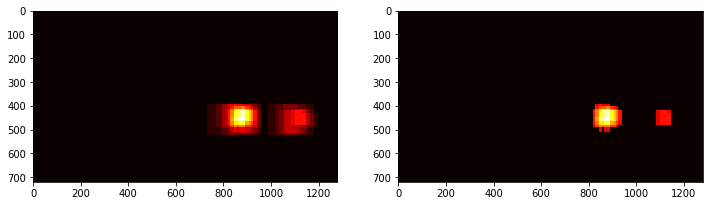

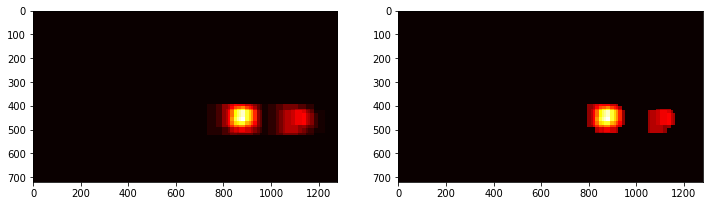

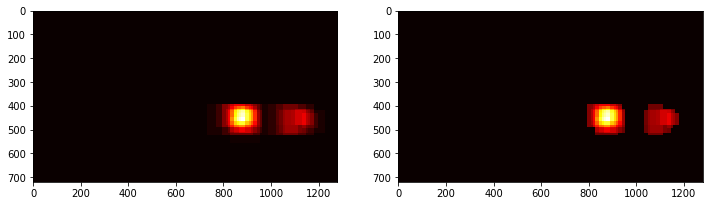

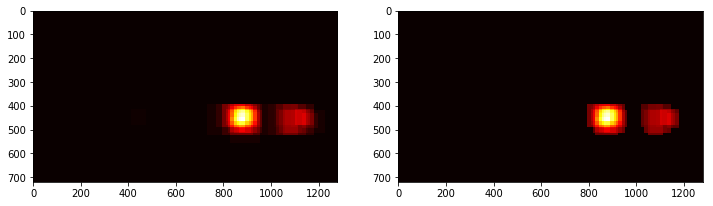

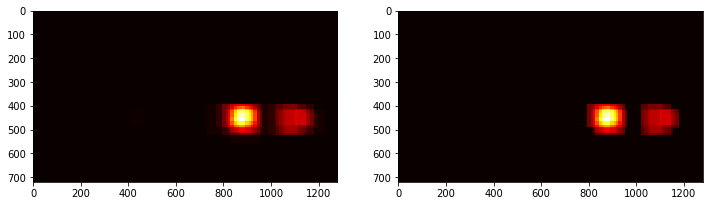

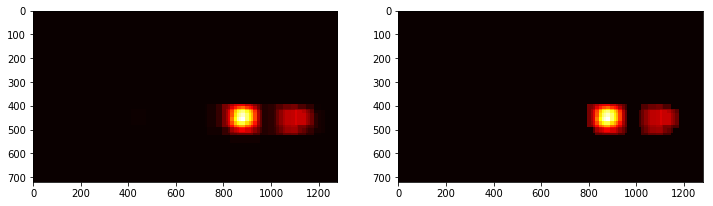

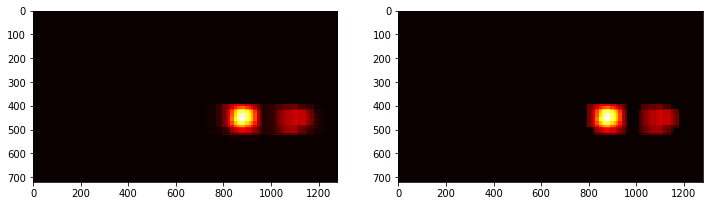

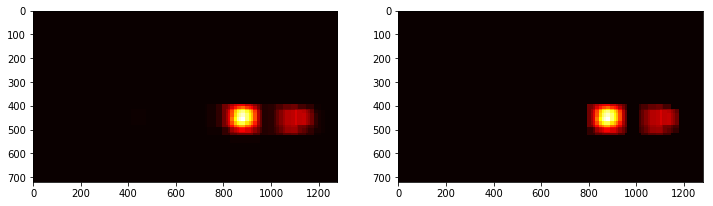

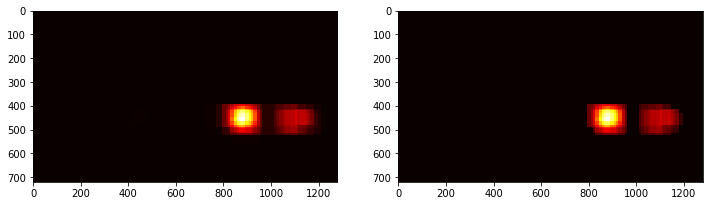

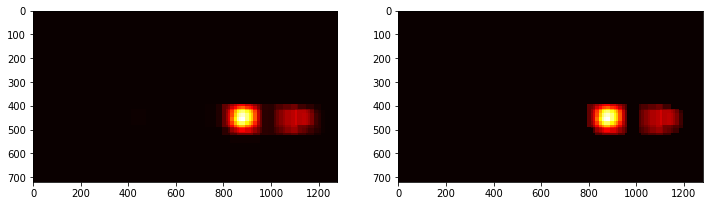

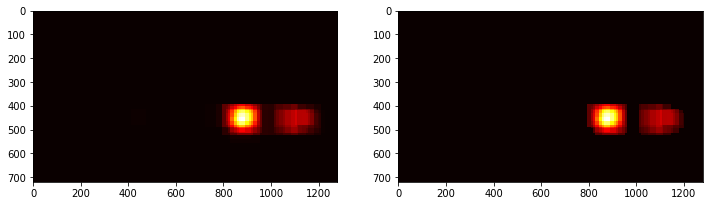

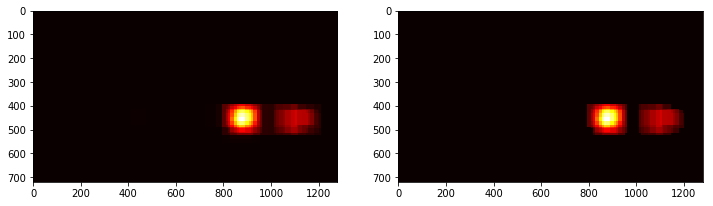

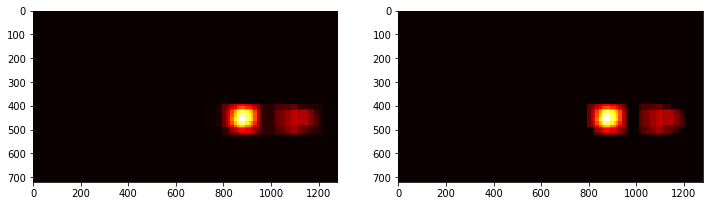

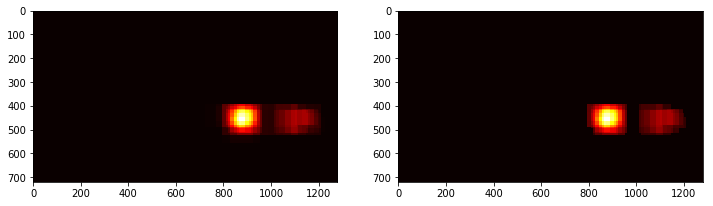

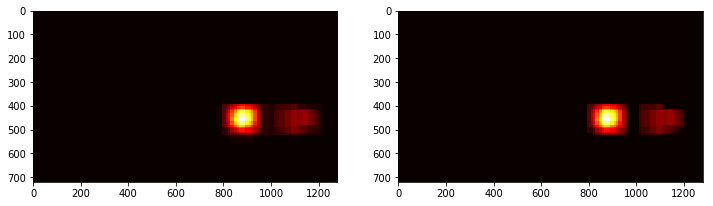

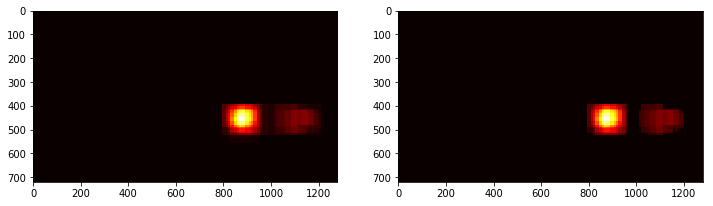

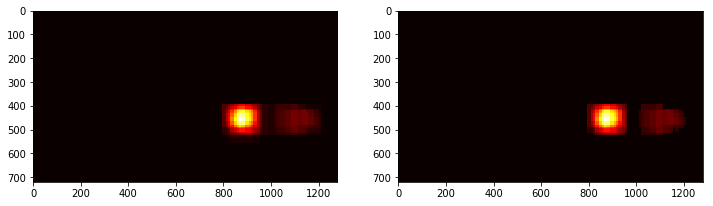

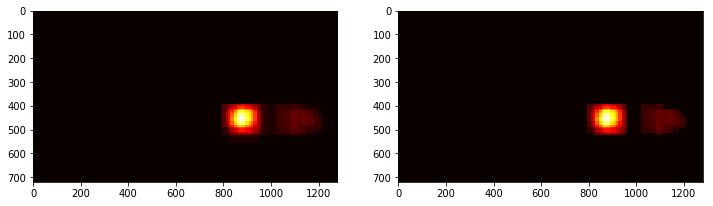

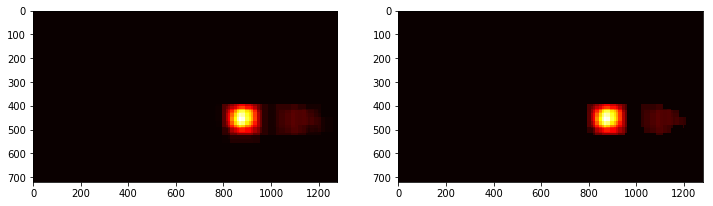

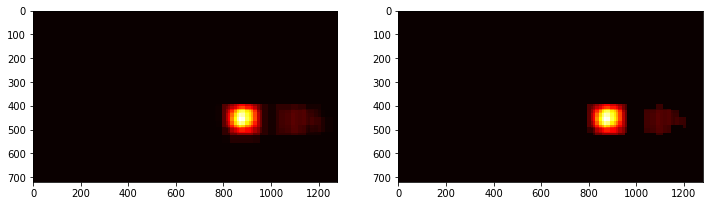

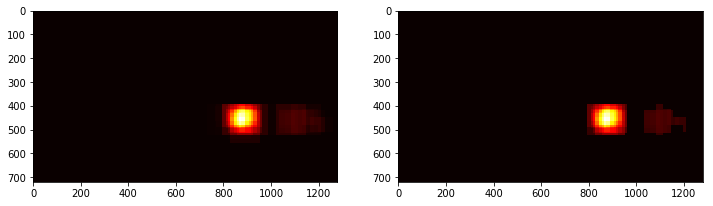

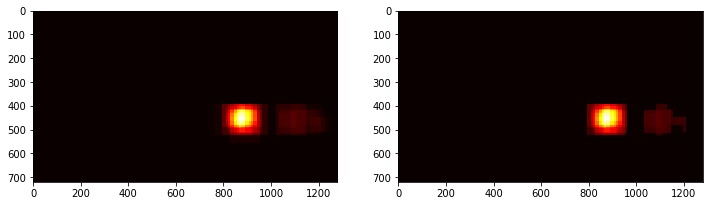

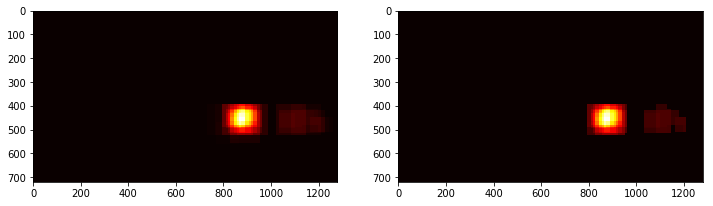

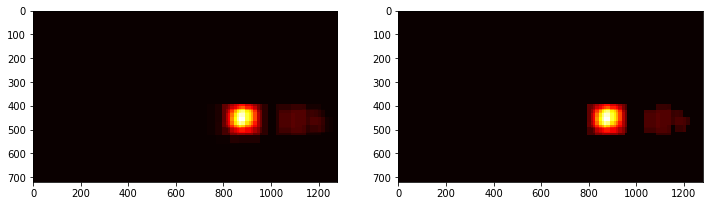

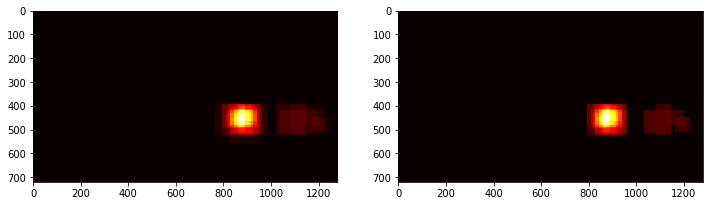

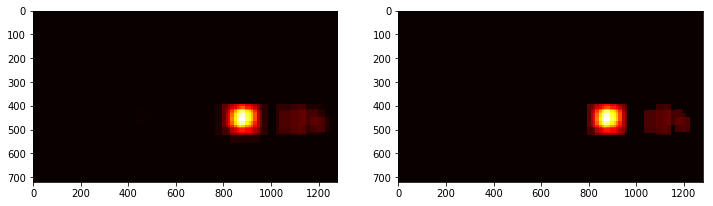

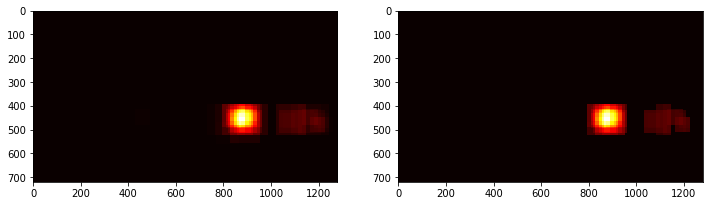

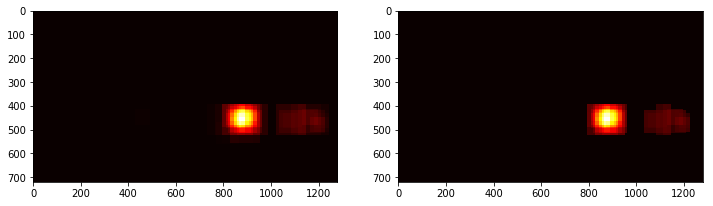

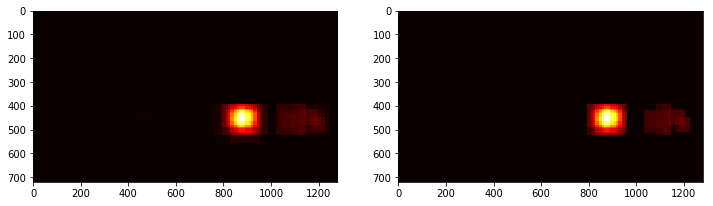

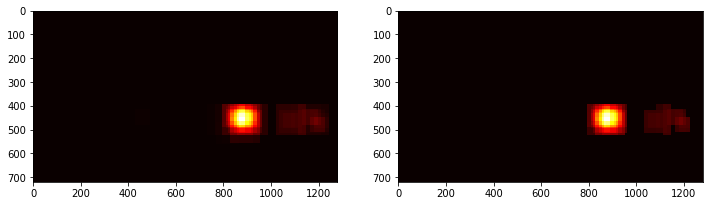

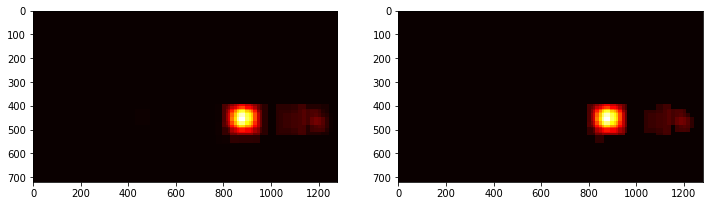

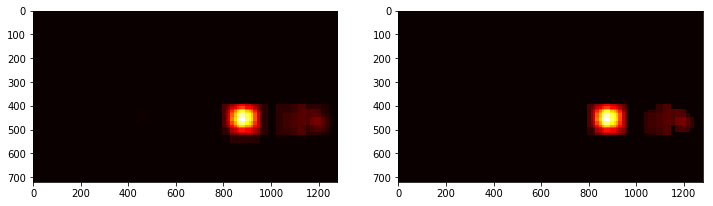

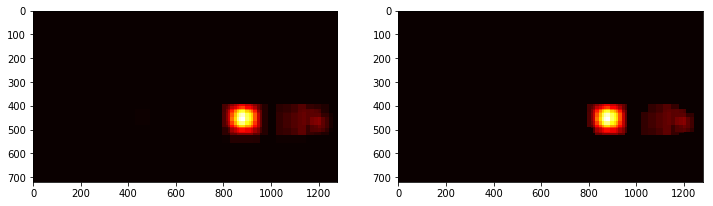

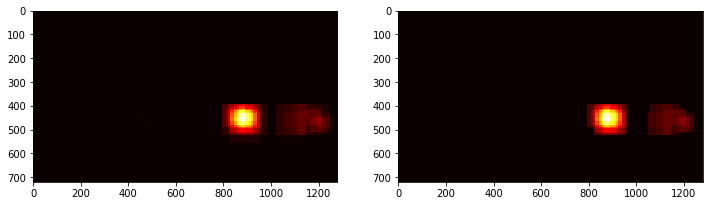

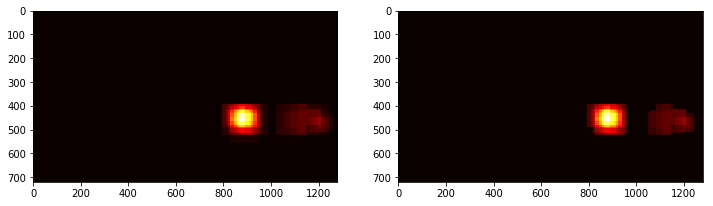

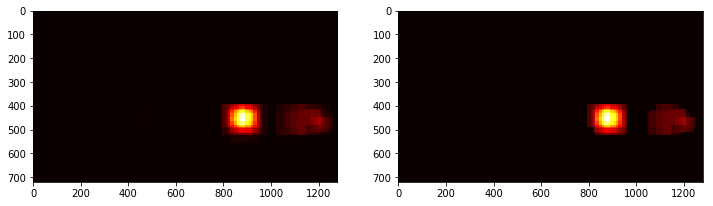

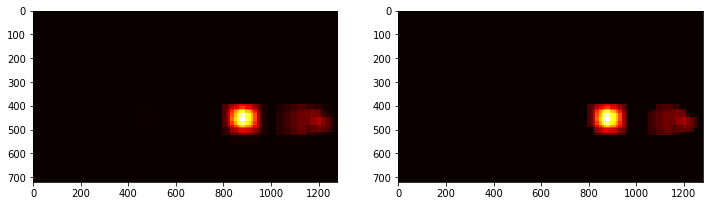

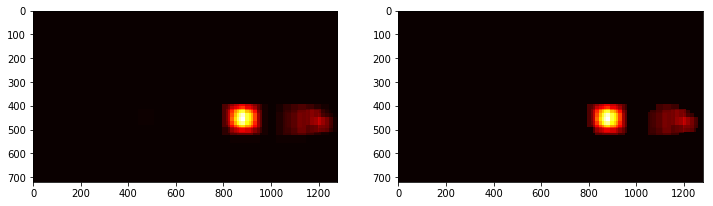

[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/test_video_result.mp4 



In [51]:
threshold = 10
num_history = 9

car_detector = CarDetector(window_list, threshold, classifier=svc,  scaler=X_scaler, 
                           cspace=cspace, pix_per_cell=pix_per_cell, hog_channel=hog_channel, num_history=num_history,
                           diagnosis=True)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'test_video.mp4').as_posix())
white_clip = clip1.fl_image(car_detector.process) #NOTE: this function expects color images!!
white_clip.write_videofile((VIDEO_OUTPUT_PATH/'test_video_result.mp4').as_posix(), audio=False, progress_bar=False)

In [ ]:
%%time
threshold = 13
num_history = 9

car_detector = CarDetector(window_list, threshold, classifier=svc,  scaler=X_scaler, 
                           cspace=cspace, pix_per_cell=pix_per_cell, hog_channel=hog_channel, num_history=num_history,
                           diagnosis=False)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'project_video.mp4').as_posix())
white_clip = clip1.fl_image(car_detector.process) #NOTE: this function expects color images!!
white_clip.write_videofile(
    (VIDEO_OUTPUT_PATH/'project_video_result_ver2_1.mp4').as_posix(), 
    audio=False, progress_bar=True, threads=8)

[MoviePy] >>>> Building video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/project_video_result_ver2_1.mp4
[MoviePy] Writing video /home/downloads/carnd-p5-vehicle-detection/videos/test_videos_result/project_video_result_ver2_1.mp4


 99%|█████████▉| 1250/1261 [35:56<00:18,  1.72s/it]